# TED 2D CAMUS - Temporal consistency

In [1]:
# Imports
from skimage import io
import os
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2
import re
from matplotlib.lines import Line2D
import SimpleITK as sitk

# Full cardiac cycle A4C - Visualization

In [26]:
# Base directory
os.chdir('D:/TFG/TED/database')

In [27]:
def visualization(patient, frame, seq_path, seq_gt_path, seq_pred_path):
    # Read files
    seq = io.imread(seq_path, plugin='simpleitk')
    seq_gt = io.imread(seq_gt_path, plugin='simpleitk')
    seq_pred = io.imread(seq_pred_path, plugin='simpleitk')

    # Plot images
    fig = plt.figure(figsize=(15, 5))
    gs = fig.add_gridspec(1, 3, hspace=0.1, wspace=0.1)
    (ax1, ax2, ax3) = gs.subplots(sharex='col', sharey='row')

    # Frame
    ax1.imshow(seq[frame], cmap='gray')
    ax1.set_title('Patient {} frame {}'.format(patient, frame))
    ax1.axis('auto')

    # Frame ground truth
    ax2.imshow(seq_gt[frame], cmap='gray')
    ax2.set_title('Ground truth')
    ax2.axis('auto')
    
    # Frame predicted
    ax3.imshow(seq_pred[frame], cmap='gray')
    ax3.set_title('Predicted')
    ax3.axis('auto')

In [28]:
# Base directory
os.chdir('D:/TFG/TED/individual_pred')

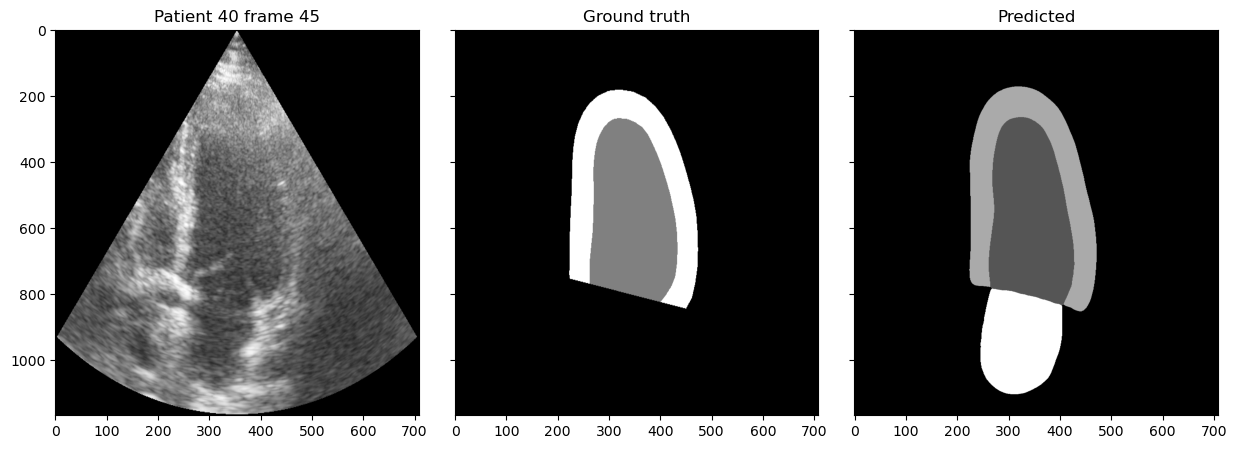

In [29]:
patient = '40' # From 01 to 98
frame = 45
seq_path = 'D:/TFG/TED/database/patient0{}/patient0{}_4CH_sequence.mhd'.format(patient, patient)
seq_gt_path = 'D:/TFG/TED/database/patient0{}/patient0{}_4CH_sequence_gt.mhd'.format(patient, patient)
seq_pred_path = 'D:/TFG/TED/individual_pred/patient0{}_4CH.nii'.format(patient)
    
visualization(patient, frame, seq_path, seq_gt_path, seq_pred_path)

## 1 Temporal evaluation

## 1.1. Quantitative assessment

In [1]:
# Paths
'D:/TFG/TED/groundtruth/patient0{}_4CH_{}.nii'
'D:/TFG/TED/Results_680/patient0{}_4CH_{}.nii'
'D:/TFG/TED/Task300_2DLeftVentricle/prediction_300/patient0{}_4CH_0{}.nii.gz'
'D:/TFG/TED/Task685_2DLeftVentricle/prediction_685/patient0{}_4CH_0{}.nii.gz'
'D:/TFG/TED/Task690_2DLeftVentricle/prediction_690/patient0{}_4CH_0{}.nii.gz'
'D:/TFG/TED/Task695_2DLeftVentricle/prediction_695/patient0{}_4CH_0{}.nii.gz'
'D:/TFG/TED/Task700_2DLeftVentricle/prediction_700/patient0{}_4CH_0{}.nii.gz'
'D:/TFG/TED/Task705_2DLeftVentricle/prediction_705/patient0{}_4CH_0{}.nii.gz'
'D:/TFG/TED/Task800_2DLeftVentricle/prediction_800_lowres/patient0{}_4CH_0{}.nii.gz'
'D:/TFG/TED/Task800_2DLeftVentricle/prediction_800_fullres/patient0{}_4CH_0{}.nii.gz'

'D:/TFG/TED/Task800_2DLeftVentricle/prediction_800_fullres/patient0{}_4CH_0{}.nii.gz'

In [20]:
pixels_Endo_final = []
pixels_Myo_final = []
pixels_ED_final = []

for j in range(80, 99):
    gt_path = 'D:/TFG/TED/database/patient0{}/patient0{}_4CH_sequence_gt.mhd'.format(j, j)
    seq_gt = io.imread(gt_path, plugin='simpleitk')
    pixels_Endo = []
    pixels_Myo = []
    pixels_ED = []
    
    pixels_ED.append(np.sum(seq_gt[0] == 1))
    pixels_ED_final.append(pixels_ED)

    for i in range(1, seq_gt.shape[0]-1):
        if i > 9:
            pred_path = 'D:/TFG/TED/groundtruth/patient0{}_4CH_{}.nii'.format(j, i)
            seq_pred = io.imread(pred_path, plugin='simpleitk')
        else:
            pred_path = 'D:/TFG/TED/groundtruth/patient0{}_4CH_0{}.nii'.format(j, i)
            seq_pred = io.imread(pred_path, plugin='simpleitk')

        pixels_Endo.append(np.sum(seq_pred[0] == 1))
        pixels_Myo.append(np.sum(seq_pred[0] == 2))

    pixels_Endo_final.append(pixels_Endo)
    pixels_Myo_final.append(pixels_Myo)

### 1.1.1. Compute smoothness using second derivative

In [21]:
def smoothness(list):
    
    # Second derivative
    second_derivate = np.gradient(np.gradient(list))

    # Mean absolute value as a measure of smoothness
    smoothness = np.mean(np.abs(second_derivate))

    return smoothness

In [22]:
sum_smooth = 0

for i in range(0, 19):
    
    smooth_value = smoothness(pixels_Endo_final[i])
    normalized_smooth_value = smooth_value / pixels_ED_final[i]
    sum_smooth += normalized_smooth_value
    
print(sum_smooth / len(pixels_Endo_final))

[0.0026587]


### 1.1.2. Compute smoothness using finit differences

In [23]:
def finit_differences(list):
    
    finit_difference = 0
    for i in range(0, 19):
        
        diff = np.mean(np.abs(np.diff(list[i])))
        finit_difference += diff/pixels_ED_final[i]
        
    print(finit_difference/len(list))

In [24]:
finit_differences(pixels_Endo_final)

[0.01676912]


## 2.1. Qualitative assessment

In [26]:
def count_pixels(patient, path):
    
    sequence = io.imread(path, plugin='simpleitk')

    pixels_4CH_Endo = []
    pixels_4CH_Myo = []

    for i in range(0, sequence.shape[0]):
        pixels_4CH_Endo.append(np.sum(sequence[i] == 1)) # 1 correspond to the LV Endo
        pixels_4CH_Myo.append(np.sum(sequence[i] == 2)) # 2 correspond to the LV Epi
        
    return pixels_4CH_Endo, pixels_4CH_Myo

In [41]:
# Patient from 80 to 98
patient = input('Enter patient (80-98): ')

# Paths
gt_path = 'D:/TFG/TED/database/patient0{}/patient0{}_4CH_sequence_gt.mhd'.format(patient, patient)
seq_gt = io.imread(gt_path, plugin='simpleitk')

ind_path = 'D:/TFG/TED/individual_pred/patient0{}_4CH.nii'.format(patient)
lowres = 'D:/TFG/TED/Task800_2DLeftVentricle/prediction_800_lowres_full/patient0{}_4CH.nii.gz'.format(patient)
fullres = 'D:/TFG/TED/Task800_2DLeftVentricle/prediction_800_fullres_full/patient0{}_4CH.nii.gz'.format(patient)
# Count pixels
### Ground Truth ###
pixels_4CH_Endo_gt, pixels_4CH_Myo_gt = count_pixels(patient, gt_path)
### Task 300 ###
pixels_4CH_Endo, pixels_4CH_Myo = count_pixels(patient, ind_path)
### Task 800 lowres ###
pixels_4CH_Endo2, pixels_4CH_Myo2 = count_pixels(patient, lowres)
### Task 800 fullres ###
pixels_4CH_Endo3, pixels_4CH_Myo3 = count_pixels(patient, fullres)

### Task 600 ###
pixels_first_temporal_Endo = []
pixels_first_temporal_Myo = []

for i in range(1, seq_gt.shape[0]-1):
    if i > 9:
        pred_path = 'D:/TFG/TED/Results/patient0{}_4CH_{}.nii'.format(patient, i)
        seq_pred = io.imread(pred_path, plugin='simpleitk')
    else:
        pred_path = 'D:/TFG/TED/Results/patient0{}_4CH_0{}.nii'.format(patient, i)
        seq_pred = io.imread(pred_path, plugin='simpleitk')
        
    pixels_first_temporal_Endo.append(np.sum(seq_pred[0] == 1))
    pixels_first_temporal_Myo.append(np.sum(seq_pred[0] == 2))
    
### Task 680 ###
pixels_temporal_Endo = []
pixels_temporal_Myo = []

for i in range(2, seq_gt.shape[0]-1):
    if i > 9:
        pred_path = 'D:/TFG/TED/Results_680/patient0{}_4CH_{}.nii'.format(patient, i)
        seq_pred = io.imread(pred_path, plugin='simpleitk')
    else:
        pred_path = 'D:/TFG/TED/Results_680/patient0{}_4CH_0{}.nii'.format(patient, i)
        seq_pred = io.imread(pred_path, plugin='simpleitk')
        
    pixels_temporal_Endo.append(np.sum(seq_pred[0] == 1))
    pixels_temporal_Myo.append(np.sum(seq_pred[0] == 2))

pixels_temporal_Endo.insert(0, pixels_temporal_Endo[0])

### Task 685 ###
pixels_third_temporal_Endo = []
pixels_third_temporal_Myo = []

for i in range(2, seq_gt.shape[0]-1):
    if i > 9:
        pred_path = 'D:/TFG/TED/Task685_2DLeftVentricle/prediction_685/patient0{}_4CH_{}.nii.gz'.format(patient, i)
        seq_pred = io.imread(pred_path, plugin='simpleitk')
    else:
        pred_path = 'D:/TFG/TED/Task685_2DLeftVentricle/prediction_685/patient0{}_4CH_0{}.nii.gz'.format(patient, i)
        seq_pred = io.imread(pred_path, plugin='simpleitk')
        
    pixels_third_temporal_Endo.append(np.sum(seq_pred[0] == 1))
    pixels_third_temporal_Myo.append(np.sum(seq_pred[0] == 2))

### Task 690 ###
pixels_fourth_temporal_Endo = []
pixels_fourth_temporal_Myo = []

for i in range(0, seq_gt.shape[0]-2):
    if i > 9:
        pred_path = 'D:/TFG/TED/Task690_2DLeftVentricle/prediction_690/patient0{}_4CH_{}.nii'.format(patient, i)
        seq_pred = io.imread(pred_path, plugin='simpleitk')
    else:
        pred_path = 'D:/TFG/TED/Task690_2DLeftVentricle/prediction_690/patient0{}_4CH_0{}.nii'.format(patient, i)
        seq_pred = io.imread(pred_path, plugin='simpleitk')
        
    pixels_fourth_temporal_Endo.append(np.sum(seq_pred[0] == 1))
    pixels_fourth_temporal_Myo.append(np.sum(seq_pred[0] == 2))

### Task 695 ###
pixels_fifth_temporal_Endo = []
pixels_fifth_temporal_Myo = []

for i in range(0, seq_gt.shape[0]-2):
    if i > 9:
        pred_path = 'D:/TFG/TED/Task695_2DLeftVentricle/prediction_695/patient0{}_4CH_{}.nii'.format(patient, i)
        seq_pred = io.imread(pred_path, plugin='simpleitk')
    else:
        pred_path = 'D:/TFG/TED/Task695_2DLeftVentricle/prediction_695/patient0{}_4CH_0{}.nii'.format(patient, i)
        seq_pred = io.imread(pred_path, plugin='simpleitk')
        
    pixels_fifth_temporal_Endo.append(np.sum(seq_pred[0] == 1))
    pixels_fifth_temporal_Myo.append(np.sum(seq_pred[0] == 2))
    
### Task 700 ###
pixels_700_Endo = []
pixels_700_Myo = []

for i in range(0, seq_gt.shape[0]):
    if i > 9:
        pred_path = 'D:/TFG/TED/Task700_2DLeftVentricle/prediction_700/patient0{}_4CH_{}.nii'.format(patient, i)
        seq_pred = io.imread(pred_path, plugin='simpleitk')
    else:
        pred_path = 'D:/TFG/TED/Task700_2DLeftVentricle/prediction_700/patient0{}_4CH_0{}.nii'.format(patient, i)
        seq_pred = io.imread(pred_path, plugin='simpleitk')
        
    pixels_700_Endo.append(np.sum(seq_pred[0] == 1))
    pixels_700_Myo.append(np.sum(seq_pred[0] == 2))
    
    
### Task 705 ###
pixels_705_Endo = []
pixels_705_Myo = []

for i in range(1, seq_gt.shape[0]-1):
    if i > 9:
        pred_path = 'D:/TFG/TED/Task705_2DLeftVentricle/prediction_705/patient0{}_4CH_{}.nii'.format(patient, i)
        seq_pred = io.imread(pred_path, plugin='simpleitk')
    else:
        pred_path = 'D:/TFG/TED/Task705_2DLeftVentricle/prediction_705/patient0{}_4CH_0{}.nii'.format(patient, i)
        seq_pred = io.imread(pred_path, plugin='simpleitk')
        
    pixels_705_Endo.append(np.sum(seq_pred[0] == 1))
    pixels_705_Myo.append(np.sum(seq_pred[0] == 2))

Enter patient (80-98): 93


## 2.1.1. Consectuive training 

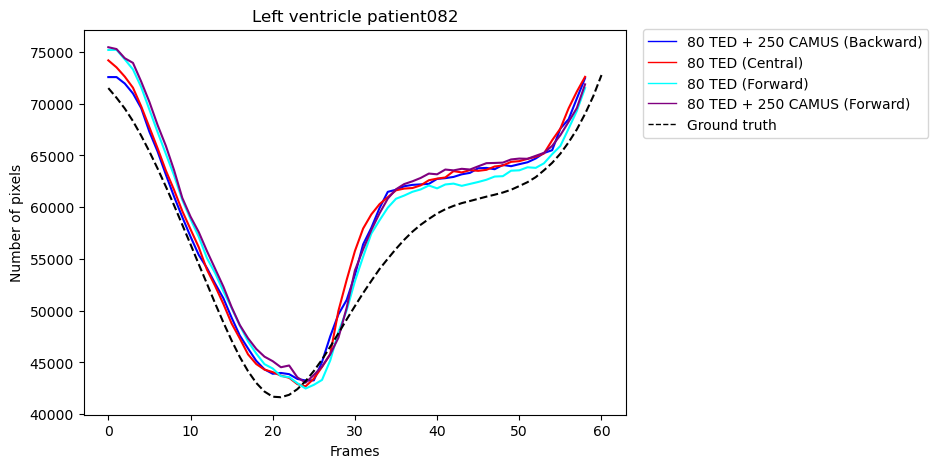

In [102]:
# Create figure
fig = plt.figure(figsize=(7, 5))
gs = fig.add_gridspec(1, 1, hspace=0.1, wspace=0.1)
ax1 = gs.subplots(sharex='col', sharey='row')
    
# LV Endocardium
ax1.plot(pixels_temporal_Endo, 'blue', label = 'LV Endo') 
ax1.plot(pixels_705_Endo, 'red', label = 'LV Endo')
ax1.plot(pixels_fourth_temporal_Endo, 'cyan', label = 'LV Endo')
ax1.plot(pixels_fifth_temporal_Endo, 'purple', label = 'LV Endo')
ax1.plot(pixels_4CH_Endo_gt, 'black', linestyle='dashed', label = 'LV Endo gt') # Ground truth

LV_Endo = [Line2D([0], [0], color='blue', lw=1, label='80 TED + 250 CAMUS (Backward)'),
           Line2D([0], [0], color='red', lw=1, label='80 TED (Central)'),
           Line2D([0], [0], color='cyan', lw=1, label='80 TED (Forward)'),
           Line2D([0], [0], color='purple', lw=1, label='80 TED + 250 CAMUS (Forward)'),
           Line2D([0], [0], color='black', lw=1, label='Ground truth', linestyle='dashed')]

# Legends
legend = ax1.legend(handles=LV_Endo, loc='upper right', bbox_to_anchor=(1.57, 1.02))

ax1.set_xlabel("Frames")
ax1.set_ylabel("Number of pixels")
# ax1.set_ylim(30000, 55000)
ax1.set_title("Left ventricle patient0{}".format(patient))
plt.show()

## 2.1.2. Individual training

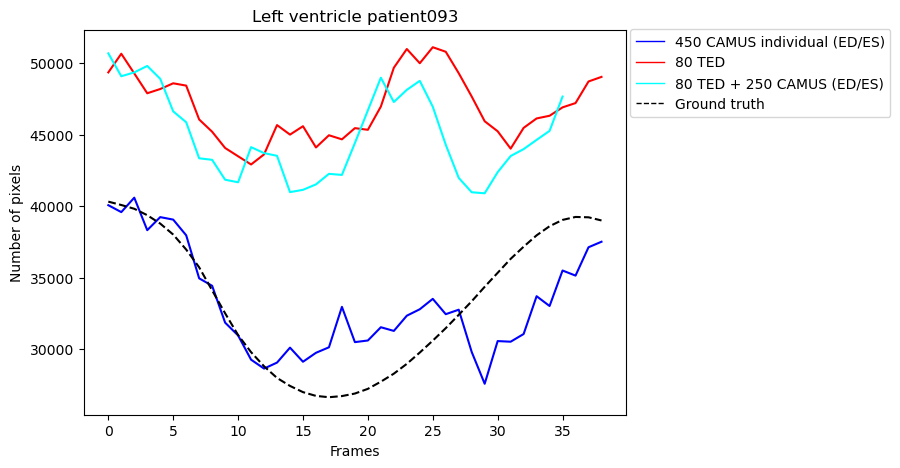

In [42]:
# Create figure
fig = plt.figure(figsize=(7, 5))
gs = fig.add_gridspec(1, 1, hspace=0.1, wspace=0.1)
ax1 = gs.subplots(sharex='col', sharey='row')
    
# LV Endocardium
ax1.plot(pixels_4CH_Endo, 'blue',label = 'LV Endo') # 450 CAMUS 
ax1.plot(pixels_700_Endo, 'red',label = 'LV Endo') # 80 + 250
ax1.plot(pixels_third_temporal_Endo, 'cyan',label = 'LV Endo') # 80 TED
ax1.plot(pixels_4CH_Endo_gt, 'black', linestyle='dashed', label = 'LV Endo gt') # Ground truth


LV_Endo = [Line2D([0], [0], color='blue', lw=1, label='450 CAMUS individual (ED/ES)'),
           Line2D([0], [0], color='red', lw=1, label='80 TED'),
           Line2D([0], [0], color='cyan', lw=1, label='80 TED + 250 CAMUS (ED/ES)'),
           Line2D([0], [0], color='black', lw=1, label='Ground truth', linestyle='dashed')]

# Legends
legend = ax1.legend(handles=LV_Endo, loc='upper right', bbox_to_anchor=(1.50, 1.02))

ax1.set_xlabel("Frames")
ax1.set_ylabel("Number of pixels")
# ax1.set_ylim(30000, 55000)
ax1.set_title("Left ventricle patient0{}".format(patient))
plt.show()

## 2.1.3. 2D + t

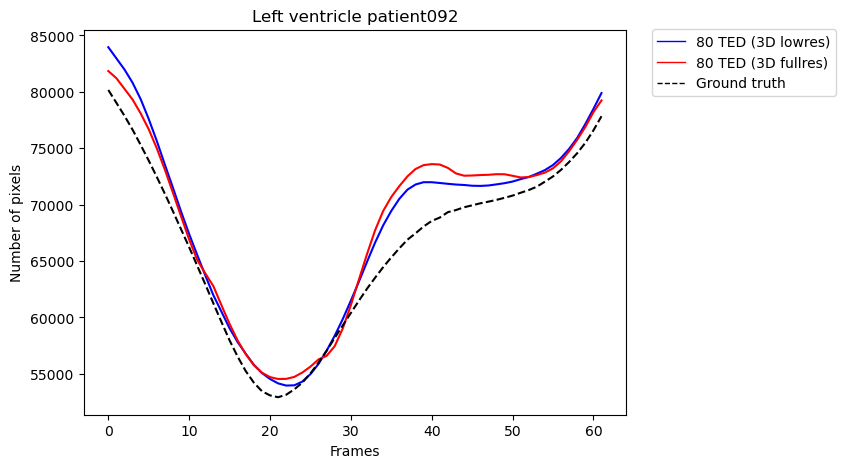

In [15]:
# Create figure
fig = plt.figure(figsize=(7, 5))
gs = fig.add_gridspec(1, 1, hspace=0.1, wspace=0.1)
ax1 = gs.subplots(sharex='col', sharey='row')
    
# LV Endocardium
ax1.plot(pixels_4CH_Endo2, 'blue',label = 'LV Endo') # First temporal prediction
ax1.plot(pixels_4CH_Endo3, 'red',label = 'LV Endo') # First temporal prediction
ax1.plot(pixels_4CH_Endo_gt, 'black', linestyle='dashed', label = 'LV Endo gt') # Ground truth

LV_Endo = [Line2D([0], [0], color='blue', lw=1, label='80 TED (3D lowres)'),
           Line2D([0], [0], color='red', lw=1, label='80 TED (3D fullres)'),
           Line2D([0], [0], color='black', lw=1, label='Ground truth', linestyle='dashed')]

# Legends
legend = ax1.legend(handles=LV_Endo, loc='upper right', bbox_to_anchor=(1.4, 1.02))

ax1.set_xlabel("Frames")
ax1.set_ylabel("Number of pixels")
ax1.set_title("Left ventricle patient0{}".format(patient))
# ax1.set_ylim(30000, 55000)
plt.show()

## 2.1.4. Individual vs Consecutive vs 2D + t

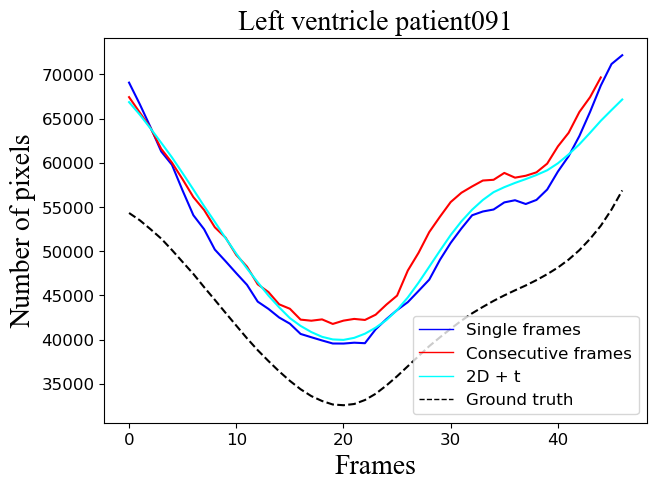

In [40]:
# Create figure
fig = plt.figure(figsize=(7, 5))
gs = fig.add_gridspec(1, 1, hspace=0.1, wspace=0.1)
ax1 = gs.subplots(sharex='col', sharey='row')
csfont = {'fontname':'Times New Roman'}
    
# LV Endocardium
ax1.plot(pixels_700_Endo, 'blue',label = 'Individual') # 80 + 250(ed/es)
ax1.plot(pixels_fifth_temporal_Endo, 'red', label = 'Consecutive') # 80 + 250 (Forward)
ax1.plot(pixels_4CH_Endo2, 'cyan',label = '2D + t') # 2D + t lowres
ax1.plot(pixels_4CH_Endo_gt, 'black', linestyle='dashed', label = 'LV Endo gt') # Ground truth

LV_Endo = [Line2D([0], [0], color='blue', lw=1, label='Single frames'),
           Line2D([0], [0], color='red', lw=1, label='Consecutive frames'),
           Line2D([0], [0], color='cyan', lw=1, label='2D + t'),
           Line2D([0], [0], color='black', lw=1, label='Ground truth', linestyle='dashed')]

# Legends
# legend = ax1.legend(handles=LV_Endo, loc='upper right', bbox_to_anchor=(1.57, 1.02))
ax1.legend(handles=LV_Endo, loc='lower right', fontsize='large')

ax1.set_xlabel("Frames", fontsize=20, **csfont)
ax1.set_ylabel("Number of pixels", fontsize=20, **csfont)
ax1.set_title("Left ventricle patient0{}".format(patient), fontsize=20, **csfont)

plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

plt.show()

In [17]:
# Paths
'D:/TFG/TED/groundtruth/patient0{}_4CH_{}.nii'
'D:/TFG/TED/Results_680/patient0{}_4CH_{}.nii'
'D:/TFG/TED/Task300_2DLeftVentricle/patient0{}_4CH_0{}.nii.gz'
'D:/TFG/TED/Task680_2DLeftVentricle/summary_new.json'
'D:/TFG/TED/Task685_2DLeftVentricle/summary_new.json'
'D:/TFG/TED/Task600_2DLeftVentricle/summary_new.json'
'D:/TFG/TED/Task690_2DLeftVentricle/summary_new.json'
'D:/TFG/TED/Task695_2DLeftVentricle/summary_new.json'
'D:/TFG/TED/Task700_2DLeftVentricle/summary_new.json'
'D:/TFG/TED/Task705_2DLeftVentricle/summary_new.json'
'D:/TFG/TED/Task800_2DLeftVentricle/prediction_800_fullres/summary.json'
'D:/TFG/TED/Task800_2DLeftVentricle/prediction_800_lowres/summary.json'

'D:/TFG/TED/Task800_2DLeftVentricle/prediction_800_lowres/summary.json'

In [19]:
# Load JSON data
with open('D:/TFG/TED/Task685_2DLeftVentricle/summary_new.json', 'r') as f:
    data = json.load(f)

# Load .nii
for patient in range(80, 99):
    print('Patient {}'.format(patient))
    gt_path = 'D:/TFG/TED/database/patient0{}/patient0{}_4CH_sequence_gt.mhd'.format(patient, patient)
    seq_gt = io.imread(gt_path, plugin='simpleitk')

    lv_dict = {}
    myo_dict = {}

    # Extract Dice metric
    for i in range(len(data["results"]["all"])):
        if str(patient) in data["results"]["all"][i]['test']:
            lv_dict[data["results"]["all"][i]['test'].split('/')[4].split('_')[2].split('.')[0]] = (data["results"]["all"][i]["1"]["Dice"])
            myo_dict[data["results"]["all"][i]['test'].split('/')[4].split('_')[2].split('.')[0]] = (data["results"]["all"][i]["2"]["Dice"])

    # Get minimum LV
    min_lv_dice = min(lv_dict.values())
    min_lv = [key for key in lv_dict if lv_dict[key]==min_lv_dice]
    
    print('LV: Frame {} with Dice: {}'.format(min_lv[0], min_lv_dice))

    # Get minimum Myo
    min_myo_dice = min(myo_dict.values())
    min_myo = [key for key in myo_dict if myo_dict[key]==min_myo_dice]

    print('Myo: Frame {} with Dice: {}\n'.format(min_myo[0], min_myo_dice))

Patient 80
LV: Frame 22 with Dice: 0.917162999878449
Myo: Frame 22 with Dice: 0.7808907244112067

Patient 81
LV: Frame 18 with Dice: 0.9149765628625794
Myo: Frame 23 with Dice: 0.8569593061773504

Patient 82
LV: Frame 33 with Dice: 0.950815631244883
Myo: Frame 03 with Dice: 0.8436327005408517

Patient 83
LV: Frame 20 with Dice: 0.8925316518055076
Myo: Frame 01 with Dice: 0.8042301270050094

Patient 84
LV: Frame 26 with Dice: 0.8998414473765072
Myo: Frame 31 with Dice: 0.8328800036266376

Patient 85
LV: Frame 62 with Dice: 0.9054479998177164
Myo: Frame 62 with Dice: 0.8140034845690648

Patient 86
LV: Frame 14 with Dice: 0.848899593480394
Myo: Frame 19 with Dice: 0.7188080662996021

Patient 87
LV: Frame 32 with Dice: 0.9423665766971353
Myo: Frame 27 with Dice: 0.8538334252619967

Patient 88
LV: Frame 24 with Dice: 0.8985511752269618
Myo: Frame 25 with Dice: 0.8468437745114756

Patient 89
LV: Frame 20 with Dice: 0.9066202575704838
Myo: Frame 21 with Dice: 0.8402486961436683

Patient 90
LV

In [2]:
def interpolate(dice, id_es, num_points_dias, num_points_sys):
    t1 = np.linspace(0, id_es - 1, num_points_sys)
    t2 = np.linspace(id_es, len(dice), num_points_dias)
    t = np.concatenate([t1, t2])
    
    interpolated_values = np.interp(t, np.arange(len(dice)), dice)

    return interpolated_values

In [21]:
# DO IT FOR
# - 450 CAMUS (ED/ES) SINGLE
# - 80 TED + 250 CAMUS (ES) CONSECUTIVE BACKWARD
# - 80 TED 3D FULL RES

lv_dict = {}

num_points_dias = 26
num_points_sys = 25
mean_interpolated_arrays = {}

# Extract Dice metric
# Load JSON data
# 'D:/TFG/TED/individual_pred'
# with open('D:/TFG/TED/Task300_2DLeftVentricle/summary_new.json', 'r') as f:
# with open('D:/TFG/TED/Task680_2DLeftVentricle/summary_new.json', 'r') as f:
with open('D:/TFG/TED/Task800_2DLeftVentricle/prediction_800_fullres/summary.json', 'r') as f:
    data = json.load(f)

for patient in range(80, 99):
    for i in range(len(data["results"]["all"])):
        if ('0' + str(patient)) in data["results"]["all"][i]['test']:
            lv_dict[data["results"]["all"][i]['test'].split('/')[4].split('_')[2].split('.')[0]] = (data["results"]["all"][i]["1"]["Dice"])

    with open('D:/TFG/TED/database/patient0{}/patient0{}_4CH_info.cfg'.format(patient, patient)) as f:
        for line in f:
            if 'ES:' in line:
                id_es = int(line.split()[1]) - 1  # Subtract 1 to convert to zero-based index
                break
            
    dice = list(lv_dict.values())
    interpolated_array = interpolate(dice, id_es, num_points_dias, num_points_sys)
    
    mean_interpolated_arrays[patient] = interpolated_array

num_indices = len(mean_interpolated_arrays[80]) 

final_mean_array = np.zeros(num_indices)

for index in range(num_indices):
    mean_values = [mean_interpolated_arrays[patient][index] for patient in range(80, 81)]
    final_mean_array[index] = np.mean(mean_values)

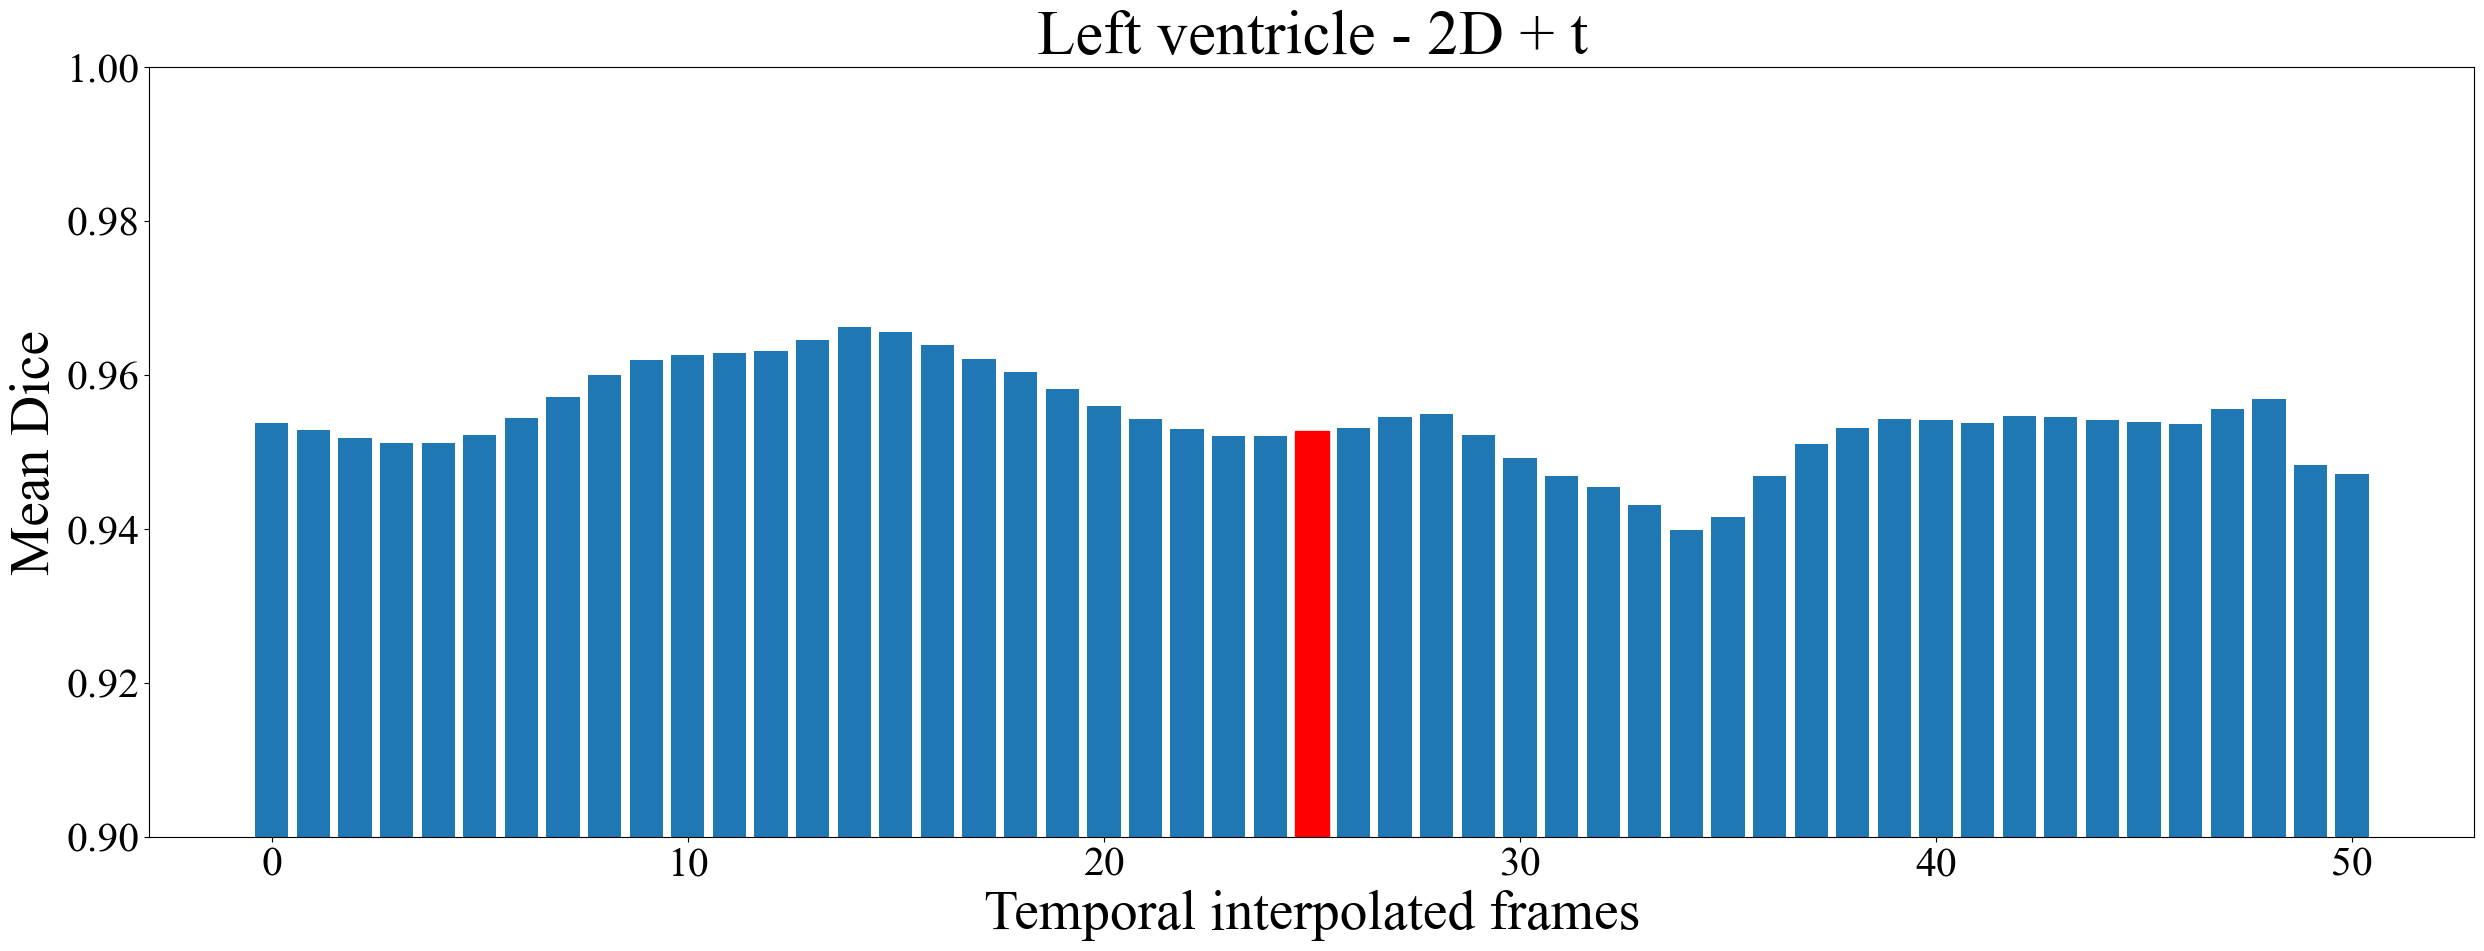

In [22]:
fig = plt.figure(figsize=(30, 10))
gs = fig.add_gridspec(1, 1, hspace=0.1, wspace=0.1)
ax1 = gs.subplots(sharex='col', sharey='row')
csfont = {'fontname':'Times New Roman'}
ax1.set_title("Left ventricle - 2D + t", fontsize=45, **csfont)
ax1.set_xlabel("Temporal interpolated frames", fontsize=40, **csfont)
ax1.set_ylabel("Mean Dice", fontsize=40, **csfont)


bars = ax1.bar(range(len(final_mean_array)), final_mean_array)
bars[25].set_color('red')
ax1.set_ylim(0.9, 1.0)
plt.xticks(fontsize=30, **csfont)
plt.yticks(fontsize=30, **csfont)
plt.show()

# 3. GIFs setup

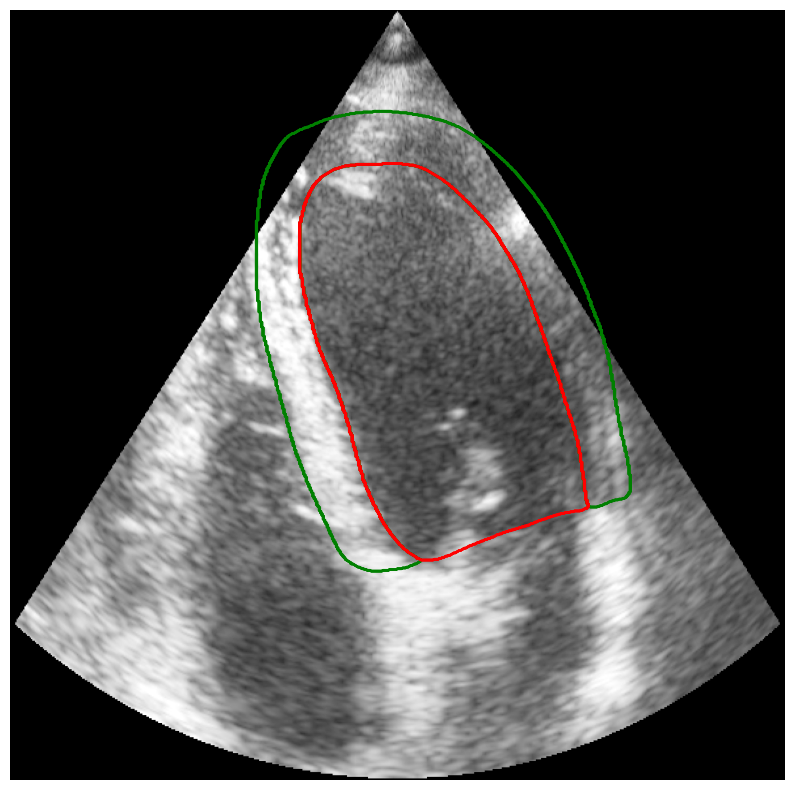

In [16]:
patient = 80
frame = 49

seq_pred_path = 'D:/TFG/TED/Task800_2DLeftVentricle/prediction_800_lowres/patient0{}_4CH_{}.nii'.format(patient, frame)
seq_path = 'D:/TFG/TED/database/patient0{}/patient0{}_4CH_sequence.mhd'.format(patient, patient)
seq_path_gt = 'D:/TFG/TED/database/patient0{}/patient0{}_4CH_sequence_gt.mhd'.format(patient, patient)

seq_pred = io.imread(seq_pred_path, plugin='simpleitk')
seq = io.imread(seq_path, plugin='simpleitk')
seq_gt = io.imread(seq_path_gt, plugin='simpleitk')

fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(1, 1, hspace=0.1, wspace=0.1)
(ax1) = gs.subplots(sharex='col', sharey='row')
ax1.axis('off')

ax1.imshow(seq[frame], cmap='gray')
ax1.contour(seq_pred[0]==2, colors='g', linewidths = 1.5)
ax1.contour(seq_pred[0]==1, colors='r', linewidths = 1.5)
ax1.axis('auto')

for ax in fig.get_axes():
    ax.label_outer()

## 3.1. GIFs creation

In [11]:
os.chdir('D:/TFG/TED/Task300_2DLeftVentricle')
for patient in range(80, 99):
    if (os.path.exists('animation/patient0{}'.format(patient)) == False):
        os.mkdir('animation/patient0{}.'.format(patient))

    seq_path = 'D:/TFG/TED/database/patient0{}/patient0{}_4CH_sequence.mhd'.format(patient, patient)
    seq = io.imread(seq_path, plugin='simpleitk')

    for frame in range(0, seq.shape[0]):
                
        if frame > 9:
            seq_pred_path = 'D:/TFG/TED/Task300_2DLeftVentricle/prediction_300/patient0{}_4CH_{}.nii'.format(patient, frame)
        else:
            seq_pred_path = 'D:/TFG/TED/Task300_2DLeftVentricle/prediction_300/patient0{}_4CH_0{}.nii'.format(patient, frame)

        seq_pred = io.imread(seq_pred_path, plugin='simpleitk')

        fig = plt.figure(figsize=(10, 10))
        gs = fig.add_gridspec(1, 1, hspace=0.1, wspace=0.1)
        (ax1) = gs.subplots(sharex='col', sharey='row')
        ax1.axis('off')

        ax1.imshow(seq[frame], cmap='gray')
        ax1.contour(seq_pred[0]==2, colors='g', linewidths = 1.5)
        ax1.contour(seq_pred[0]==1, colors='r', linewidths = 1.5)
        ax1.axis('auto')

        for ax in fig.get_axes():
            ax.label_outer()

        fig.savefig('animation/patient0{}/frame_{}.png'.format(patient, frame), bbox_inches='tight', transparent=True, pad_inches=0)

        plt.close(frame)

    plt.close(seq.shape[0])

In [12]:
import imageio.v2 as imageio
import os 

# Save GIF
for patient in range(80, 99):
    os.chdir('D:/TFG/TED/Task300_2DLeftVentricle/animation/patient0{}'.format(patient))
    filenames = os.listdir('D:/TFG/TED/Task300_2DLeftVentricle/animation/patient0{}'.format(patient))
    sorted_filenames = sorted(filenames, key=lambda x: int(re.search(r'\d+', x).group()))

    with imageio.get_writer('Patient0{}.gif'.format(patient), mode='I') as writer:
        for filename in sorted_filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

## 3.2. GIFs display

In [2]:
from IPython.display import Image, display, Markdown
import ipywidgets as widgets

patient = int(input('Choose a patient (80-98): '))
Task680_path = 'D:/TFG/TED/Task680_2DLeftVentricle/animation/patient0{}/Patient0{}.gif'.format(patient, patient)
Task685_path = 'D:/TFG/TED/Task685_2DLeftVentricle/animation/patient0{}/Patient0{}.gif'.format(patient, patient)
Task690_path = 'D:/TFG/TED/Task690_2DLeftVentricle/animation/patient0{}/Patient0{}.gif'.format(patient, patient)
Task695_path = 'D:/TFG/TED/Task695_2DLeftVentricle/animation/patient0{}/Patient0{}.gif'.format(patient, patient)
Task700_path = 'D:/TFG/TED/Task700_2DLeftVentricle/animation/patient0{}/Patient0{}.gif'.format(patient, patient)
Task705_path = 'D:/TFG/TED/Task705_2DLeftVentricle/animation/patient0{}/Patient0{}.gif'.format(patient, patient)
Task705_path = 'D:/TFG/TED/Task800_2DLeftVentricle/animation_fullres/patient0{}/Patient0{}.gif'.format(patient, patient)

with open(Task680_path, "rb") as f1, open(Task685_path, "rb") as f2, open(Task690_path, "rb") as f3, open(Task695_path, "rb") as f4, open(Task700_path, "rb") as f5, open(Task705_path, "rb") as f6:
    gif_680 = widgets.Image(value=f1.read(), format='png', width=450, height=450)
    gif_685 = widgets.Image(value=f2.read(), format='png', width=450, height=450)
    gif_690 = widgets.Image(value=f3.read(), format='png', width=450, height=450)
    gif_695 = widgets.Image(value=f4.read(), format='png', width=450, height=450)
    gif_700 = widgets.Image(value=f5.read(), format='png', width=450, height=450)
    gif_705 = widgets.Image(value=f6.read(), format='png', width=450, height=450)
    vbox = widgets.HBox([gif_680, gif_700]) # gif_690, gif_695, gif_700, gif_705
    hbox = widgets.HBox([gif_690, gif_695])
    zbox = widgets.HBox([gif_700, gif_705])
    display(vbox)
    display(hbox)
    display(zbox)

Choose a patient (80-98): 80
